# Data import

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats

In [2]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

Most of the scatter plots look llike this which is why I did not go with any logistic regression model in machine learning section

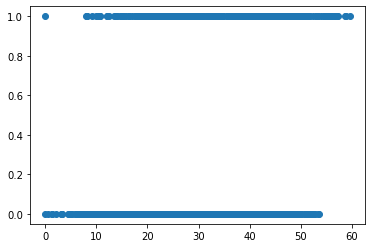

In [4]:
plt.scatter(df["total day charge"], df['churn']) 

## Data Transformation

In [5]:
def plan_to_num(plan):
    if plan == "yes":
        return 1
    elif plan == "no":
        return 0
    return plan

In [6]:
df['international plan'] = df['international plan'].apply(plan_to_num)
df['voice mail plan'] = df['voice mail plan'].apply(plan_to_num)

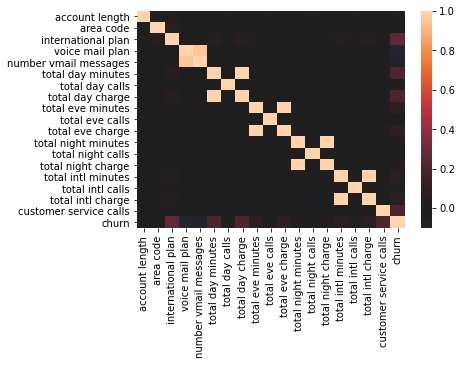

In [30]:
sns.heatmap(df.drop(['state', 'phone number'], axis=1).corr(), center=0);

## Data split

In [7]:
X = df.drop(['churn'], axis=1)
y = df['churn']

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   int64  
 5   voice mail plan         3333 non-null   int64  
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

Preparing the data for machine learning process

In [9]:
X.drop(['state'], axis=1, inplace=True)
X.drop(['phone number'], axis=1, inplace=True)
X = pd.concat([pd.get_dummies(df['state']), X], axis=1)

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=314159)

Transforming the data using SMOTE to account for the imbalance in data

In [12]:
from imblearn.over_sampling import SMOTE

In [13]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

# Classify data

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, \
recall_score, classification_report, make_scorer, roc_curve, auc

recall_scorer = make_scorer(recall_score)

In [15]:
dt_clf = DecisionTreeClassifier()
dt_cv_score = cross_val_score(dt_clf, X_train_resampled, y_train_resampled, cv=3, scoring=recall_scorer)
mean_dt_cv_score = dt_cv_score.mean()

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 87.09%


In [16]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [6, 12, 18, 24, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [17]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=5, scoring=recall_scorer)

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)

dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

#dt_y_score = dt_grid_search.decision_function(X_test)

print(f"Training Recall Score: {dt_grid_search.best_score_ :.2%}")
print(f"Test Recall Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Training Recall Score: 88.73%
Test Recall Score: 64.75%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [18]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train_resampled, y_train_resampled, cv=5, scoring=recall_scorer))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 92.85%


In [19]:
rf_param_grid = {'bootstrap': [True, False],
                 'max_depth': [6, 12, 18, 24, 30],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10],
}

In [20]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3, scoring=recall_scorer)

rf_grid_search.fit(X_train_resampled, y_train_resampled)

rf_gs_testing_score = rf_grid_search.score(X_test, y_test)

#rf_y_score = rf_grid_search.decision_function(X_test)

print(f"Training Recall Score: {rf_grid_search.best_score_ :.2%}")
print(f"Testing Recall: {rf_gs_testing_score :.2%}")
print("")
print("Best Parameter Combination Found During Grid Search:")
rf_grid_search.best_params_

Training Recall Score: 93.36%
Testing Recall: 52.46%

Best Parameter Combination Found During Grid Search:


{'bootstrap': False,
 'max_depth': 24,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [21]:
dt_score = dt_grid_search.score(X_test, y_test)
rf_score = rf_grid_search.score(X_test, y_test)

print('Decision tree grid search: ', dt_score)
print('Random forest grid search: ', rf_score)

Decision tree grid search:  0.6475409836065574
Random forest grid search:  0.5245901639344263


In [22]:
rf_estimator = rf_grid_search.best_estimator_
dt_estimator = dt_grid_search.best_estimator_

rf_fi = rf_estimator.feature_importances_
dt_fi = dt_estimator.feature_importances_

In [23]:
rf_dict = dict(zip(X.columns, rf_fi))
df_dict = dict(zip(X.columns, dt_fi))
joined = {}
for key in X.columns:
    joined[key] = [rf_dict[key], df_dict[key]]

In [24]:
j = pd.DataFrame.from_dict(joined).transpose()
j.columns = ["Random Forest", "Decision Tree"]
pd.set_option('display.max_rows', 70)
j

,Random Forest,Decision Tree
AK,0.001382,0.000000
AL,0.001760,0.001640
AR,0.000578,0.000000
AZ,0.002285,0.000000
CA,0.001162,0.000000
CO,0.001044,0.003093
CT,0.001340,0.000000
DC,0.000645,0.000000
DE,0.000923,0.001822
FL,0.001225,0.000000


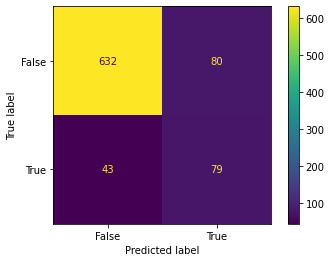

In [25]:
plot_confusion_matrix(dt_estimator, X_test, y_test);

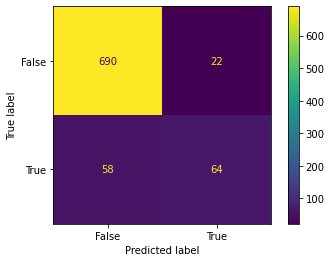

In [26]:
plot_confusion_matrix(rf_estimator, X_test, y_test);

In [28]:
dt_pred = dt_estimator.predict(X_test)
print(classification_report(y_test, dt_pred))
#fpr, tpr, thresholds = roc_curve(y_test, dt_y_score)
#print('AUC for DT: {}'.format(auc(fpr, tpr)))

              precision    recall  f1-score   support

       False       0.94      0.89      0.91       712
        True       0.50      0.65      0.56       122

    accuracy                           0.85       834
   macro avg       0.72      0.77      0.74       834
weighted avg       0.87      0.85      0.86       834



In [29]:
rf_pred = rf_estimator.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

       False       0.92      0.97      0.95       712
        True       0.74      0.52      0.62       122

    accuracy                           0.90       834
   macro avg       0.83      0.75      0.78       834
weighted avg       0.90      0.90      0.90       834

